In [2]:
import numpy as np
import tensorflow as tf
from config import Params
from wrapper_env import env_wrapper
import gym

from nn_architecures import network_builder
from models import CategoricalModel, GaussianModel
from policy import Policy
from copy import copy
import os


def draw_board(paths_x, paths_y, board, save_name):
    
    import matplotlib.pyplot as plt
    width, height = board.shape

    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    # fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(30):
        ax.plot([x, x], [0,29], color=(0.5,0.5,0.5,1))
    for y in range(30):
        ax.plot([0, 29], [y,y], color=(0.5,0.5,0.5,1))

    # draw paths
    for p in range(len(paths_x)):

        ph = plt.subplot()
        ph.plot(paths_y[p], paths_x[p], linewidth=5, color='black')

    # draw obstacles
    x_axis = []
    y_axis = []
    nets = dict()
    for x in range(width):
        for y in range(height):
            if board[x, y]!=0:
                x_axis.append(y)
                y_axis.append(x)
                if board[x, y]!=1:
                    nets[(x,y)] = board[x, y]

    ax.scatter(x_axis, y_axis, marker='s', s=250, c='k')

    for xy in nets:
        ax.text(xy[1], xy[0], str(int(nets[xy])-1), fontsize=18, color='w',
                horizontalalignment='center', verticalalignment='center')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(0,29)
    ax.set_ylim(0,29)
    
    fig.savefig(save_name, bbox_inches='tight')

# rollout using MCTS env
def rl_rollout(env, model, res_idx):

    res_folder_name = "route_results"
    if not os.path.isdir(res_folder_name):
        os.mkdir(res_folder_name)
    
    saved_fig_name = os.path.join(res_folder_name, "rl_route_board_{}.png".format(res_idx))

    env.reset()
    state = env
    done = False

    board = np.absolute(np.genfromtxt("./board.csv", delimiter=','))

    paths_x = []
    paths_y = []
    path_x = []
    path_y = []
    while not done:

        obs_vec = np.expand_dims(state.board_embedding(), axis=0)
        obs_vis = None
        path_x.append(obs_vec[0][0])
        path_y.append(obs_vec[0][1])
        mask = state.compute_mask()
        action_t, logp_t, value_t = model.get_action_logp_value({"vec_obs": obs_vec, "vis_obs": obs_vis}, mask=mask)

        # print(model.p_all({"vec_obs": obs_vec, "vis_obs": obs_vis}).numpy())
        state = state.takeAction(action_t)
        done = state.isTerminal()
        if state.pairs_idx-2>len(paths_x):
            paths_x.append(path_x)
            paths_y.append(path_y)
            path_x = []
            path_y = []
    draw_board(paths_x, paths_y, board, saved_fig_name)

    return state.getReward()


In [3]:
def paths_to_xys(paths):
    paths_x = []
    paths_y = []
    for p in paths:
        xs = [node[0] for node in p]
        ys = [node[1] for node in p]
        paths_x.append(xs)
        paths_y.append(ys)
    
    return paths_x, paths_y
    

In [3]:
def prob_DFS(state, model, deterministic=False):
    
    DFS_state = state
    pair_index = state.pairs_idx
    
    states_queue = [DFS_state]
    path = [DFS_state.head]
    
    while DFS_state.pairs_idx==pair_index:
        
        obs_vec = np.expand_dims(DFS_state.board_embedding(), axis=0)
        obs_vis = None
        mask = DFS_state.compute_mask()
        # print(mask, len(states_queue))
        if not all(mask==0):
            if deterministic:
                probs = model.p_all({"vec_obs": obs_vec, "vis_obs": obs_vis})[0]
                new_dist = probs.numpy()*mask
                # print(new_dist)
                if sum(new_dist)==0:
                    new_dist = mask
                new_dist = new_dist/sum(new_dist)
                action = np.argmax(new_dist)
            else:
                action, _, _ = model.get_action_logp_value({"vec_obs": obs_vec, "vis_obs": obs_vis}, mask=mask)
            DFS_state = DFS_state.takeAction(action)
            states_queue.append(DFS_state)
            path.append(DFS_state.head)
        elif len(states_queue)>1:
            pop_state = states_queue.pop()
            pop_state.board[pop_state.head] = 1
            DFS_state = states_queue[-1]
            DFS_state.board = pop_state.board
            # do not ahve to do this for now, but for later try of CNN
            DFS_state.board[DFS_state.head] = DFS_state.head_value
            path.pop()
        else:
            break

    # path.pop()
    return path
        
        

USE STANDARD VARIABLES
Model Summary: simple_actor_critic
Model: "simple_actor_critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_actor_critic1 (Dense) (None, 32)                160       
_________________________________________________________________
simple_actor_critic2 (Dense) (None, 32)                1056      
_________________________________________________________________
simple_actor_critic_output ( (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
Model: "simple_actor_critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_actor_critic1 (Dense) (None, 32)                160       
_________________________________________________________________
simple_actor_critic2 (De

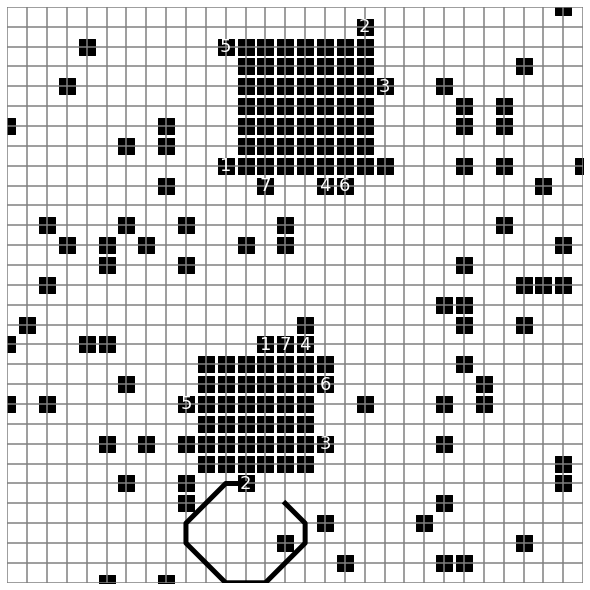

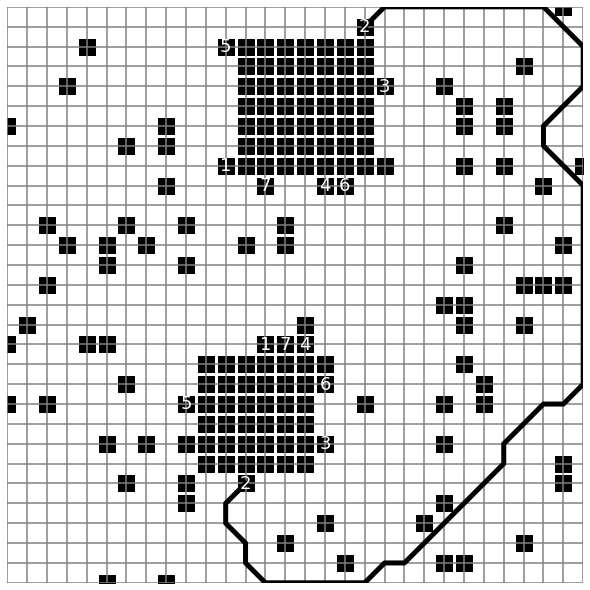

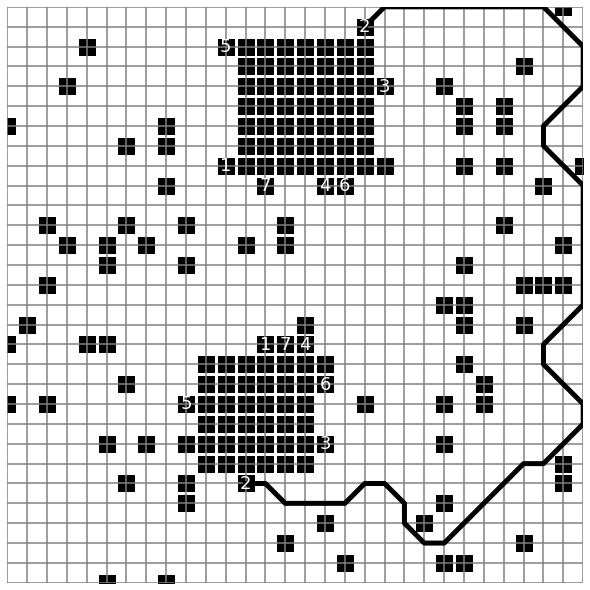

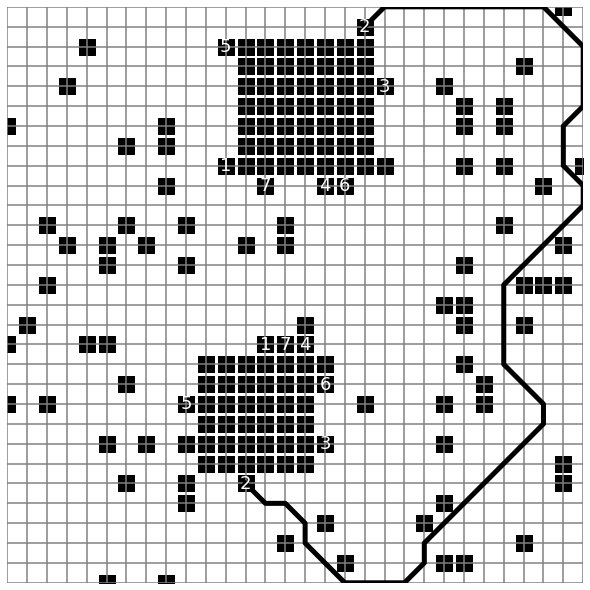

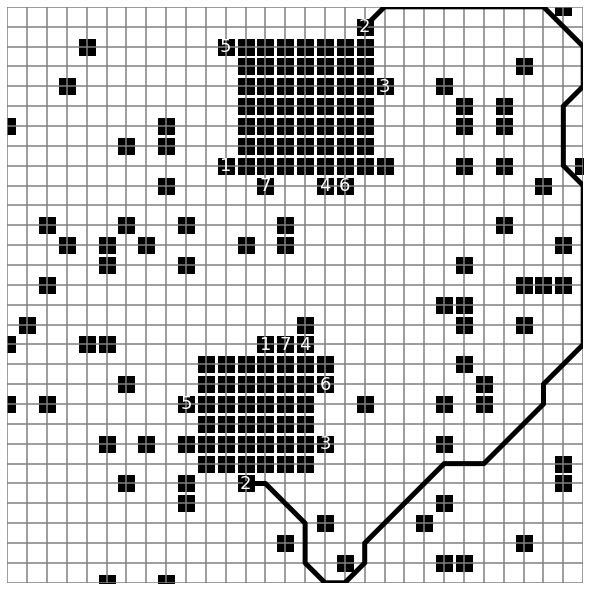

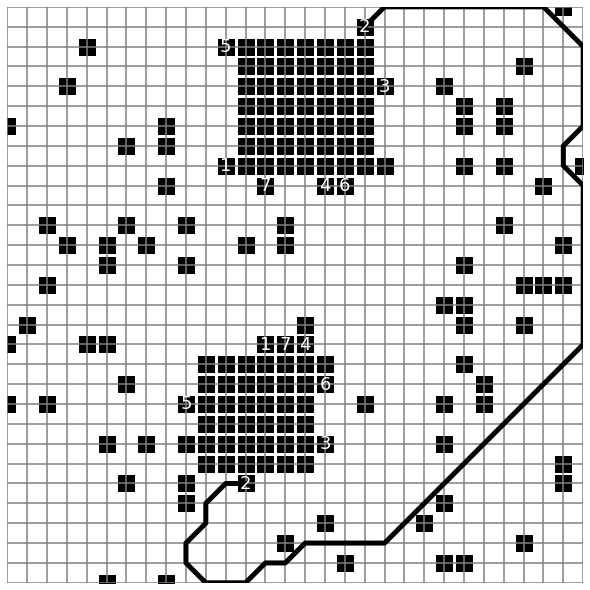

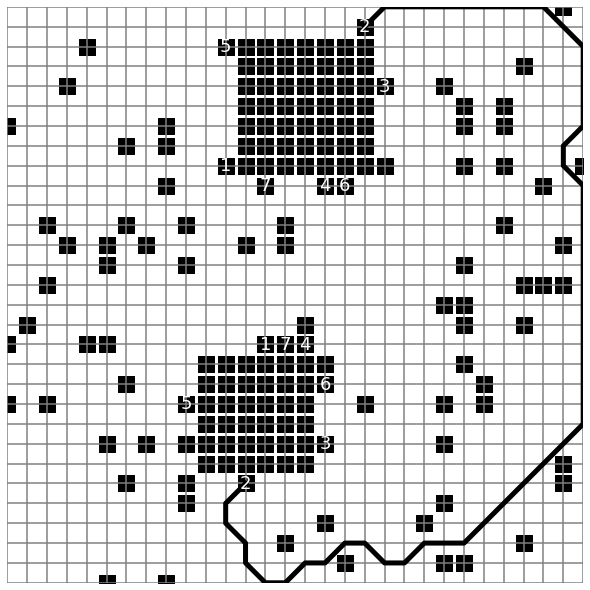

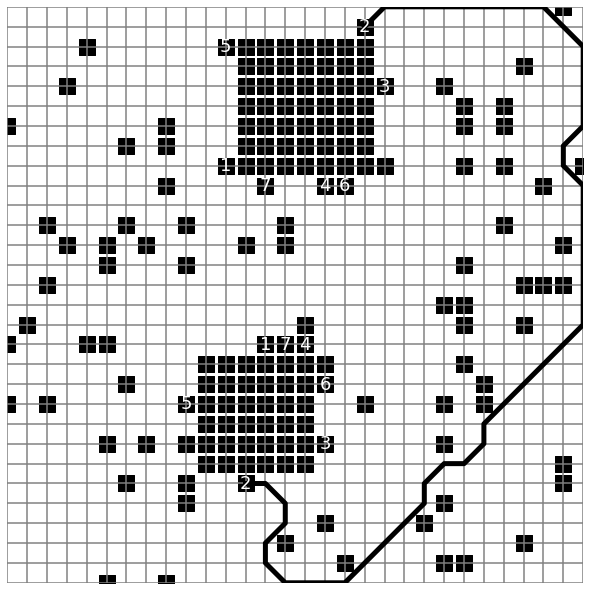

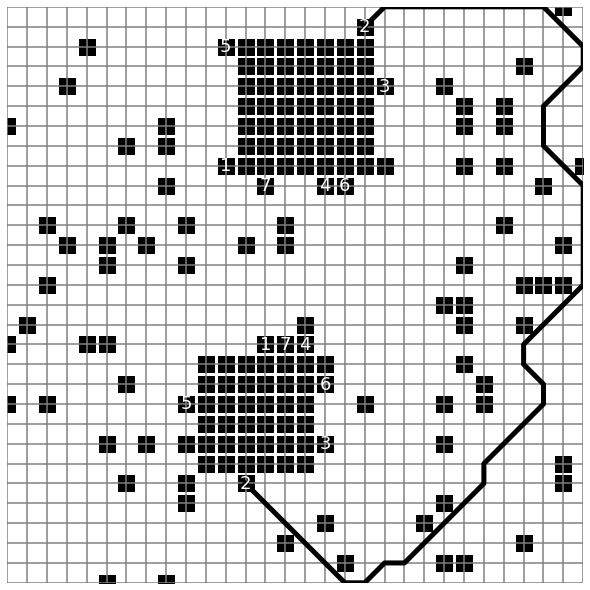

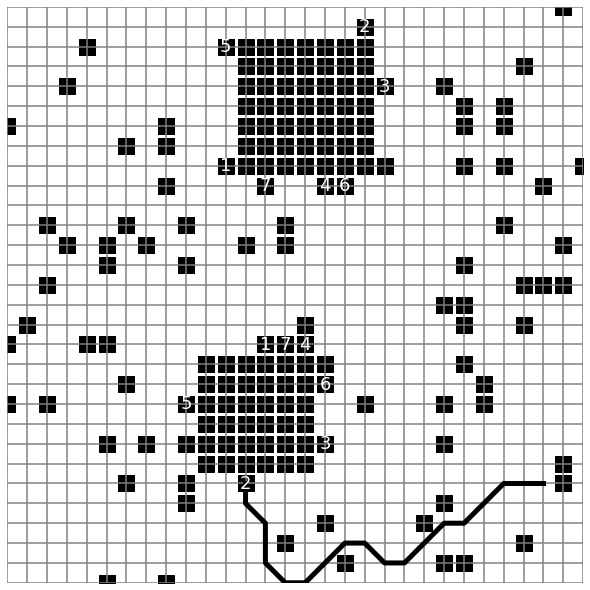

In [4]:
from CREnv_v3 import CREnv
from CREnv_v3 import CREnv_MCTS

from animate import MCTS_search

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

params = Params()

tf.random.set_seed(params.env.seed)
np.random.seed(params.env.seed)

# env = create_batched_env(params.env.num_envs, params.env)
# env = gym.make('CartPole-v0')
env = CREnv()
env = env_wrapper(env, params.env)

network = network_builder(params.trainer.nn_architecure) \
    (hidden_sizes=params.policy.hidden_sizes, env_info=env.env_info)

model = CategoricalModel if env.env_info.is_discrete else GaussianModel
model = model(network=network, env_info=env.env_info)

env_mcts = CREnv_MCTS()
# if params.trainer.load_model:
model_idx = 0
print('Loading Model ...')
model.load_weights("./saved_model/allNets_vec_oneHit_{}".format(model_idx))

env_mcts.reset()

for i in range(30, 40):
    paths = MCTS_search(env_mcts, model, i)
    # print(paths)
# env_mcts.pairs_idx = 3
# for _ in range(200):
#     path = prob_DFS(env_mcts, model, deterministic=False)

#     paths_x, paths_y = paths_to_xys([path])

#     board = np.absolute(np.genfromtxt("./board.csv", delimiter=','))

#     draw_board(paths_x, paths_y, board, "test.jpg")
# for i in range(50):
#     ep_rew = rl_rollout(env_mcts, model, i)
#     print(ep_rew)


In [8]:
# generate supervised learning/burn-in data using A star
from astar import Astar

from CREnv_v0 import CREnv
from copy import copy

env = CREnv()
env.reset()

# for net_idx in range(2, max(env.start)+1):
board = copy(env.board)
board[board==2]=0
board[board>=1]=1

start = env.start[2]
end = env.finish[2]

astar = Astar(board)
path = astar.run(start, end)

path.pop(0)
data = []
for node in path:
    sample = list(env.board_embedding())
    act = env.path_node_to_act_idx(node)
    sample.append(act)
    data.append(sample)
    env.step(act)

np.savetxt("samples.csv", data, delimiter=",")
# paths_x, paths_y = paths_to_xys([path])
# board = np.absolute(np.genfromtxt("./board.csv", delimiter=','))

# draw_board(paths_x, paths_y, board, "test.jpg")
# print(start, end)
# # print(board)
# print(result)


In [4]:
import numpy as np
a = [[1,2,3,4],[5,6,7,8]]
np.array(a)[:,0:-1]

array([[1, 2, 3],
       [5, 6, 7]])